This script creates the JRA55do scaling files to run simple RCP-style ocean heat perturbation experiments.

We alter the air temperature and downward long-wave radiation inputs as a globally-uniform but temporally variable
perturbation (here based on a sinusoid with 10-year period), following the simple RCP experiment described in

Stewart and Hogg, 2019, http://dx.doi.org/10.1016/j.ocemod.2019.101456

In addition, here we keep the relative humidity constant (see https://github.com/COSIMA/cice5/pull/59).

The perturbations are done using the libaccessom2 perturbations code, see the tutorial here https://github.com/COSIMA/access-om2/wiki/Tutorials#Scaling-the-forcing-fields


In [22]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob
import copy

In [23]:
# Define inputs and output folders:
JRAin = '/g/data/ik11/inputs/JRA-55/RYF/v1-4/' # Location of RYF JRA55-do input forcing files
Tin = JRAin + 'RYF.tas.1990_1991.nc' # Air temperature forcing file
LRin = JRAin + 'RYF.rlds.1990_1991.nc' # Longwave radiation forcing file

JRAout = '/scratch/e14/mp2135/access-om2/input/' # Output location for storing scaling files created by this script
Tout = JRAout + 'RYF.tas.1990_1991_sinusoid_x1_period12.nc' # Air temperature scaling file
LRout = JRAout + 'RYF.rlds.1990_1991_sinusoid_x1_period12.nc' # Longwave radiation scaling file

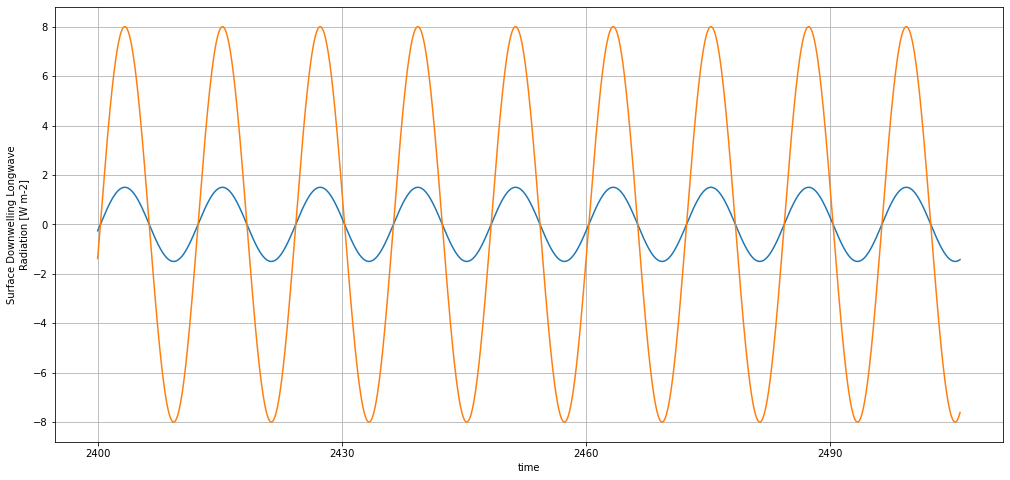

In [24]:
# Define start and end times (based on "experiment" calendar, see https://github.com/COSIMA/access-om2/wiki/Tutorials#Scaling-the-forcing-fields)

# Have some buffer either side just in case:
tstart = 2400 # start year of window in which scaling will be applied
tend = 2500 + 5 # end year of window in which scaling will be applied

seconds_in_year = (cftime.DatetimeNoLeap(1901,1,1,0,0,0,0) - cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()

# Define sinusoid properties:
Tamp = 1.5  # degrees C
LRamp = 8   # Wm-2
period = 12 * 365.25 / 365 # years. NB: Need to scale the period to get rid of the leap year calendar issue that was not resolved as at 31/08/21.

num_of_leap_day_losses = np.floor((tstart - 1900)/4 - (tstart - 1900)/100 + (tstart - 1900)/400) # number of leaps days between tstart and 1900
zeroYR = tstart - 1900 + num_of_leap_day_losses / 365  # years. determines only when the zero in the time series sinusoid, not the zero that access sees

# Extract time series and structure from original files:
Tds_in = xr.open_dataset(Tin)
LRds_in = xr.open_dataset(LRin)

timeRYF = Tds_in.time.values
timeFULL = np.concatenate(np.array([np.array([cftime.DatetimeNoLeap(year,x.month,x.day,x.hour,0,0,0) for x in timeRYF]) for year in np.arange(tstart,tend+1)])).ravel()
timeYR = np.array([(x-cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()/seconds_in_year for x in timeFULL])

# Make sinusoids:
tas_ts = Tamp*np.sin(2*np.pi*(timeYR-zeroYR)/period)
rlds_ts = LRamp*np.sin(2*np.pi*(timeYR-zeroYR)/period)

# Create new Datasets:
tas = xr.DataArray(tas_ts, dims=['time'], coords={'time': timeFULL}, attrs=Tds_in.tas.attrs)
Tds_out = Tds_in.drop_vars('tas').assign_coords({'time':timeFULL})
Tds_out['tas'] = tas
Tds_out.attrs.update({'title': 'Scaling for ' + Tds_out.attrs['title']})
Tds_out.time.attrs.update(Tds_in.time.attrs)
Tds_out.time.encoding['units'] = "days since '1900-01-01'"

rlds = xr.DataArray(rlds_ts, dims=['time'], coords={'time': timeFULL}, attrs=LRds_in.rlds.attrs)
LRds_out = LRds_in.drop_vars('rlds').assign_coords({'time':timeFULL})
LRds_out['rlds'] = rlds
LRds_out.attrs.update({'title': 'Scaling for ' + LRds_out.attrs['title']})
LRds_out.time.attrs.update(LRds_in.time.attrs)
LRds_out.time.encoding['units'] = "days since '1900-01-01'"

# Plot as check:
plt.figure(figsize=(17,8))
Tds_out.tas.plot()
LRds_out.rlds.plot()
plt.grid()

# # Save back to netcdf:
LRds_out.to_netcdf(LRout)
Tds_out.to_netcdf(Tout)